In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import functions
human = functions.Human()

In [2]:
human.age, human.gender, human.basal_metabolic_rate()

(35, 'male', 1675.8)

In [3]:
help(functions.Human())

Help on Human in module functions object:

class Human(builtins.object)
 |  Human(age: int = 35, gender: str = 'male', height: float = 1.75, weight: float = 75, position: str = 'standing', orientation: float = 0, clothingInsulation: float = None, clothingAlbedo: float = 0.37, acclimation: bool = False, metabolicRate: float = 2.32)
 |  
 |  Defines a single human, with physiological attributes against which comfort will be evaluated
 |  
 |  Methods defined here:
 |  
 |  __init__(self, age: int = 35, gender: str = 'male', height: float = 1.75, weight: float = 75, position: str = 'standing', orientation: float = 0, clothingInsulation: float = None, clothingAlbedo: float = 0.37, acclimation: bool = False, metabolicRate: float = 2.32)
 |      :param age: Age of the human
 |      :param gender: Gender of the human - either "male" or "female"
 |      :param height: Height of the human (m)
 |      :param weight: Weight of the human (kg)
 |      :param position: Body position - either "seated

In [4]:
functions.celsius_to_fahrenheit(28)

82.4

In [5]:
functions.celsius_to_kelvin(0)

273.15

In [6]:
functions.fahrenheit_to_celsius(82.4)

28.000000000000004

In [7]:
functions.heat_index(22, 30)

(21.038888888888884, 0, True)

In [8]:
functions.dewpoint_temperature(20, 50)

9.254294282076941

In [9]:
functions.humidity_index(20, 9.2)

(20.917678437748936, 0, True)

In [10]:
functions.discomfort_index(20, 50)

(18.4875, 6, True)

In [11]:
functions.wind_chill_temperature(0, 2.5)

(-3.0399222228067426, 1, False)

In [12]:
functions.wet_bulb_globe_temperature_outdoors(15, 15, 10253, 1)

(12.83225332, 0, True)

In [13]:
functions.effective_temperature(14, 58, 0.1, 0, 0.5)

(13.328, 2, False)

In [25]:
functions.wind_speed_at_height(1, 10, 100, log=True)

1.2128125949042536

In [56]:
import math

# http://www.forschung-geotechnik.org/Forschung/Geothermik/temperaturmodell.htm

soil_diffusivities = {
    "Rock": 0.02,
    "Wet clay": 0.015,
    "Wet sand": 0.01,
    "Dry clay": 0.002,
    "Dry sand": 0.001
}

angular_frequency = 2 * math.pi / 365
soil_thermal_diffusivity = soil_diffusivities["Rock"]
damping_depth = math.sqrt(2 * soil_thermal_diffusivity / angular_frequency)
annual_average_air_temperature = 21
max_avg_temperature_offset = 15
days_since_coldest_day = 4
depth = 5


ground_temperature = annual_average_air_temperature - max_avg_temperature_offset * math.exp(-depth / damping_depth) * math.cos((angular_frequency * days_since_coldest_day) - (depth / damping_depth))

print("{0:}\n{1:}\n{2:}\n{3:}\n{4:}\n{5:}".format(annual_average_air_temperature, max_avg_temperature_offset, soil_thermal_diffusivity, days_since_coldest_day, depth, ground_temperature))


21
15
0.02
4
5
21.56301529313202


# Approximating Fangers standing/sitting function

In [85]:
import numpy as np

# Load spline data
spline_sit = np.loadtxt("/Users/Tristan/Desktop/GitHub/climate/sit_spline_az_alt_temp.dat", delimiter=',', dtype=float)

# Altitudes
alts = np.arange(0, 91)

# Simplify
exponents = []
for azs in spline_sit:
    pfit = np.polyfit(alts, azs, deg=10)
    p = np.poly1d(pfit)
    exponents.append(np.array(p))

spline_sit = [i.tolist() for i in exponents] # Convert to lists
p = np.poly1d(spline_sit[0]) # Get poly1d for later prediction
p(alts) # Predict for altitudes

############################################################

# Load spline data
spline_stand = np.loadtxt("/Users/Tristan/Desktop/GitHub/climate/stand_spline_az_alt_temp.dat", delimiter=',', dtype=float)

# Altitudes
alts = np.arange(0, 91)

# Simplify
exponents = []
for azs in spline_stand:
    pfit = np.polyfit(alts, azs, deg=10)
    p = np.poly1d(pfit)
    exponents.append(np.array(p))

spline_sit = [i.tolist() for i in exponents] # Convert to lists
p = np.poly1d(spline_stand[0]) # Get poly1d for later prediction
p(alts) # Predict for altitudes

array([1.07010000e-001, 2.95347600e+001, 1.13452074e+027, 5.99028223e+042,
       9.34415971e+053, 4.61622593e+062, 5.92643275e+069, 6.10545288e+075,
       9.90833584e+080, 3.91615580e+085, 5.07711400e+089, 2.67039786e+093,
       6.66695793e+096, 8.90181601e+099, 6.97448814e+102, 3.45121561e+105,
       1.14449789e+108, 2.67001029e+110, 4.56167290e+112, 5.90302962e+114,
       5.95307046e+116, 4.79387333e+118, 3.14775922e+120, 1.71618345e+122,
       7.89305708e+123, 3.10510771e+125, 1.05774031e+127, 3.15406813e+128,
       8.31297810e+129, 1.95342688e+131, 4.12450226e+132, 7.88000267e+133,
       1.37093875e+135, 2.18448273e+136, 3.20476377e+137, 4.34950833e+138,
       5.48510815e+139, 6.45325394e+140, 7.10933045e+141, 7.35897975e+142,
       7.17985147e+143, 6.62202435e+144, 5.78922422e+145, 4.80947879e+146,
       3.80576564e+147, 2.87476364e+148, 2.07713826e+149, 1.43834041e+150,
       9.56243340e+150, 6.11385305e+151, 3.76518713e+152, 2.23680230e+153,
       1.28364528e+154, 7

In [17]:
np.arange(0, 181), np.arange(0, 91), 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [70]:


exponents

[poly1d([-2.32901681e-17,  1.05116944e-14, -1.99401437e-12,  2.05922322e-10,
        -1.25370339e-08,  4.56650326e-07, -9.78098840e-06,  1.23880296e-04,
        -1.15695672e-03,  9.78129186e-03,  3.62688485e-01]),
 poly1d([-2.21512920e-17,  1.00034842e-14, -1.89888283e-12,  1.96228806e-10,
        -1.19519195e-08,  4.35216630e-07, -9.31065444e-06,  1.18202679e-04,
        -1.13295375e-03,  9.82945656e-03,  3.62969224e-01]),
 poly1d([-2.10744877e-17,  9.52291361e-15, -1.80891177e-12,  1.87059708e-10,
        -1.13984020e-08,  4.14941659e-07, -8.86587084e-06,  1.12830921e-04,
        -1.11006792e-03,  9.87631578e-03,  3.63247563e-01]),
 poly1d([-2.00594493e-17,  9.06985380e-15, -1.72407886e-12,  1.78412935e-10,
        -1.08763626e-08,  3.95820891e-07, -8.44652225e-06,  1.07764027e-04,
        -1.08832961e-03,  9.92218310e-03,  3.63521144e-01]),
 poly1d([-1.91058710e-17,  8.64417615e-15, -1.64436178e-12,  1.70286398e-10,
        -1.03856827e-08,  3.77849806e-07, -8.05249332e-06,  1.03001

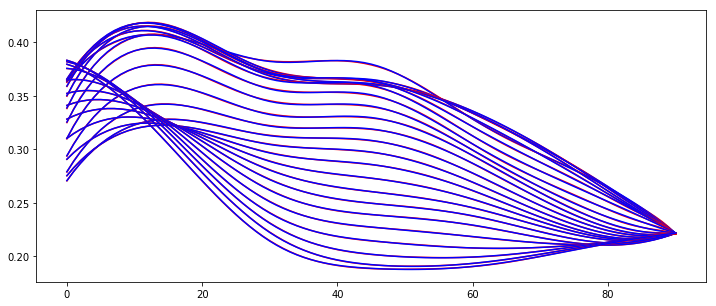

In [69]:
# spline predict
xs = np.arange(0, 91)
ys = spline[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

for ys in spline[::8]:
    z = np.polyfit(xs, ys, deg=10)
    p = np.poly1d(z)

    ax.plot(xs, p(xs), label="predicted", color="red")
    ax.plot(xs, ys, label="existing", color="blue")

# ax.legend()
# ys[45]

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

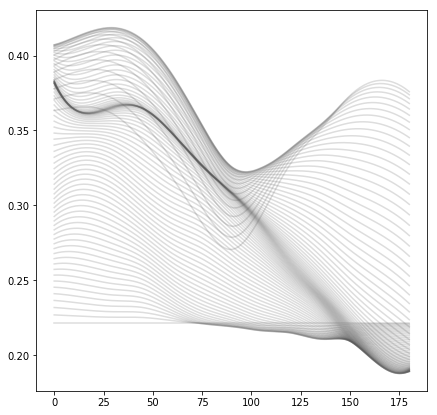

In [29]:
alt = 45
az = 0

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.plot(spline_mtx, color="#555555", alpha=0.2)